In [1]:
# COSC 522 project 2 

In [816]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sympy import lambdify
from sympy import Symbol, symbols, simplify
import sympy

In [10]:
def load_data(f):
    '''
    read data, note that the last column is label.
    args:  f --> the path or website of data

    return: X --> features
            y --> label
    '''
    
    data = pd.read_csv(f, delim_whitespace = True, header = 0)
    
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1].astype(int)
    
    return X, y

pima
120.19334888458252


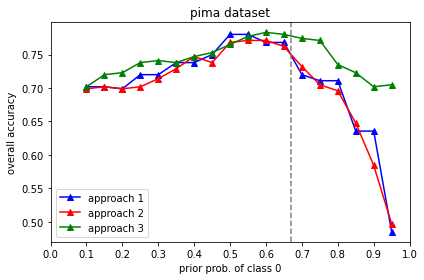

In [1498]:
class knn:
    '''Yangsong Gu'''
    ''' KNN algrorithm
    supervised learning, nonparametric learning.
    '''
    
    def __init__(self, dataset_name, k_min, k_max):
        '''initialize the parameter'''
        self.dataset_name = dataset_name  # the path of training set
        self.k_min = k_min                # limit of k value 
        self.k_max = k_max
        print(self.dataset_name)
        
    def load_data(self,f):
        '''
        read data, note that the last column is label. Note this function only separately load the data, not includes normailization
        args:  f --> the path or website of data

        return: X --> features
                y --> label
        '''
        data = pd.read_csv(f, delim_whitespace = True, header = 0)
        
        if self.dataset_name == 'pima':
            data = data.replace({'No': 1, 'Yes':0})
        else:
            data = data
        X = data.iloc[:,:-1]
        y = data.iloc[:,-1].astype(int)
            
        
        return X, y
        
    def accuracy_score(self, y, y_model):
        """ Return accuracy score.
        You are supposed to return both overall accuracy and classwise accuracy.
        args   y --> label of test sample
               y_model --> label generated from the algorithm, which is a list.
        return acc_overall --> overall accuracy, a scalar
               acc_classwise   --> classwise accuracy a dataframe
        """
        y = y.tolist() if isinstance(y, pd.Series) else y  # if y is a pd.Series, then convert it to list

        assert len(y) == len(y_model)

        # overall accuracy
        unq_label = np.unique(y)       # unique label

        # classwie accuracy, should consider situations with desigated dimensions
        # use pandas groupby
        # create a pandas dataframe
        df_eval = pd.DataFrame(list(zip(y, y_model)),
                   columns =['ytest', 'ymodel'])
        df_eval['acc'] = (df_eval['ytest'] == df_eval['ymodel']).astype(int)
        category_size = df_eval.groupby(['ytest'])['ymodel'].count().reset_index()  # count the samples in each category
        category_acc  = df_eval.groupby(['ytest'])['acc'].sum().reset_index()        # number of accurate label

        acc_classwise = pd.merge(category_size, category_acc, on = 'ytest',validate = 'one_to_one')
        acc_classwise['acc'] = acc_classwise['acc']/acc_classwise['ymodel']
        acc_classwise = acc_classwise.rename(columns = {'ytest':'category','ymodel':'cate_size','acc':'class_acc'})

        # overall accuracy
        acc_overall = df_eval['acc'].sum()/df_eval.shape[0]

        return acc_overall, acc_classwise
    
        
    def predict(self, K, Xtest, ytest, Xtrain, ytrain):
        '''
        perform KNN algorithm
        args   K      --> number of neighbors
               Xtest  --> test sample

               ....
        return y_model  --> label of classification 
               t2 - t1  --> run time (seconds)
               acc_all
               acc_class
        '''

        y_model = []   # to store the label of classification
        t1 = time.time()
#             K = 3
        for idx, row in Xtest.iterrows():

            # compute (squared or not squared) distance the sample in test set to each sample in training set
#             dist2train = (Xtrain.subtract(row)**2).sum(axis = 1)
            dist2train = ((Xtrain - row)**2).sum(axis = 1)

            neigh_idx = dist2train.sort_values().index[:K].tolist()   # K-nearest neighbour's index
            neigh_label = ytrain[neigh_idx].tolist()

            ## find the marjority of label
            major_label = max(set(neigh_label), key = neigh_label.count)
            y_model.append(major_label)

        t2 = time.time()
        if ytest is not None:
            acc_all, acc_class = self.accuracy_score(ytest, y_model)
#         print('Run time is {:.3f} seconds'.format(t2-t1))
        else:
            acc_all, acc_class = None, None

        return y_model, t2 - t1, acc_all, acc_class

    
    def iter_k(self, Xtrain, ytrain,Xtest, ytest):
        '''
        try different k in KNN, and get corresponding ovarll accuracy
        args: k_min and k_max are used to decide the boundary of k value
        return: Rt  --> runtime
                Acc_all --> overall accuracy
                Acc_class --> classwise accuracy
        '''  
        Rt = []
        Acc_all = []
        Acc_class = []

        for K in range(self.k_min,self.k_max):

            _ , runtime, acc_all_, acc_class_ = self.predict(K, Xtest, ytest, Xtrain, ytrain)
            Rt.append(runtime)
            Acc_all.append(acc_all_)
            Acc_class.append(acc_class_)

        return Rt, Acc_all, Acc_class
    
    def knn_rule1(self, neigh_label, pw):
        '''rule 1: use the prior probability to weight the number of different neighbors in each search and make a decision according to weighted votes'''
        
        label_count = [neigh_label.count(l)*pw[l] for l in range(2)]
        major_label = label_count.index(max(label_count))
        
        return major_label
    def knn_rule2(self, dist2train, neigh_idx, neigh_label, pw):
        
        '''rule 2: use distance weighted prior probability'''
        nearest_dist = dist2train[neigh_idx].tolist()
        label_weight = [ pw[x] * y for x,y in zip(neigh_label, nearest_dist)]
        label_weight = np.array(label_weight)
        denominator  = sum(label_weight)
        
        temp   = np.where(np.array(neigh_label) == 0, label_weight, 0 )
        sum_label_0 = sum(temp)  # summation of weighted cluster 0
        ps0 = sum_label_0/denominator
        
        major_label = 0 if ps0 >0.5 else 1
        
        return major_label
    
    
    def knn_rule3(self, dist2train, neigh_idx, neigh_label, pw):
        
        '''Yangsong 11:18 PM Sep, 21, 2021'''
        '''consider both fraction of votes and weighted prior probability'''
        '''current version only works for 2 clusters'''
        
        nearest_dist = dist2train[neigh_idx].tolist()
        label_weight = [ pw[x] * y for x,y in zip(neigh_label, nearest_dist)]
        label_weight = np.array(label_weight)
        denominator  = sum(label_weight)
        
        temp   = np.where(np.array(neigh_label) == 0, label_weight, 0 )
        sum_label_0 = sum(temp)  # summation of weighted cluster 0
        ps0 = sum_label_0/denominator
        
        factor2 = neigh_label.count(0)
        
        ps0_new = ps0 * (factor2/len(neigh_label))
        ps1_new = (1- ps0) *(1- factor2/len(neigh_label))
        
        major_label = 0 if ps0_new> ps1_new else 1
        
        return major_label
    
    
    def predict_(self, K, Xtest, ytest, Xtrain, ytrain, pw, case):
        '''
        perform KNN algorithm incorporate prior information.
        args   K      --> number of neighbors
               Xtest  --> test sample

               ....
        return y_model  --> label of classification 
               t2 - t1  --> run time (seconds)
               acc_all
               acc_class
        '''

        y_model = []   # to store the label of classification
        t1 = time.time()
#         pw = [0.25,0.75]  # ratio 1:3
        for idx, row in Xtest.iterrows():

            # compute (squared or not squared) distance the sample in test set to each sample in training set
#             dist2train = (Xtrain.subtract(row)**2).sum(axis = 1)
            dist2train = ((Xtrain - row)**2).sum(axis = 1)

            neigh_idx = dist2train.sort_values().index[:K].tolist()   # K-nearest neighbour's index
            neigh_label = ytrain[neigh_idx].tolist()

            ## find the marjority of label
#             major_label = max(set(neigh_label), key = neigh_label.count)
            
            # count the labels 
            # adjust 1, use prior to weight votes 
            if case == '1':
                major_label = self.knn_rule1(neigh_label, pw)
            if case == '2':
                major_label = self.knn_rule2(dist2train, neigh_idx, neigh_label, pw)
            if case == '3':
                major_label = self.knn_rule3(dist2train, neigh_idx, neigh_label, pw)
            # adjust 2, add np.log(prior)
            
            y_model.append(major_label)

        t2 = time.time()
        if ytest is not None:
            acc_all, acc_class = self.accuracy_score(ytest, y_model)
#         print('Run time is {:.3f} seconds'.format(t2-t1))
        else:
            acc_all, acc_class = None, None

        return y_model, t2 - t1, acc_all, acc_class

In [1366]:
class mpp_classifier:
    
    '''
    used to assemble three classifiers' decision boundary
    edit on Mon Sep 20, 2021 by Yangsong
    
    '''
    
    def __init__(self, X_train,y_train, xx):
        
        self.X_train = X_train     # training data
        self.y_train = y_train     # label of training data
        self.xx      = xx          # xx for plot the figure
        
    def set_variable(self):
        
        x1, x2 = symbols('x1 x2',real = True)

        return x1, x2
        
    def compute_avgcov(self):
        
        '''only used for generic form'''
        
        means = np.array([self.X_train[self.y_train == 0].mean(), self.X_train[self.y_train == 1].mean()]).reshape(2,2)
        
        arr = self.X_train[self.y_train == 0]
        covs0 = np.cov(np.transpose(arr))
        means0 = np.mean(arr, axis = 0)

        arr = self.X_train[self.y_train == 1]
        covs1 = np.cov(np.transpose(arr))
        means1 = np.mean(arr, axis = 0)

        covavg = (covs0 + covs1) / 2  
        
        return means, covs0, covs1, covavg
    
    def euclidean_distance(self):

        '''
        decision boundary for euclidean distance classifier
        args: X_train --> features of training set 
              y_train --> label of training set
              xx     --> a set of feature 1
        return: 
              yy_edist --> corresponing value of feature 2.
        '''
        means, covs0, covs1, covavg = self.compute_avgcov()
        x1, x2 = self.set_variable()
        
        edist = - 2 * (means[0,0] * x1 + means[0,1] * x2) + 2 * (means[1,0] * x1 + means[1,1] * x2) + \
                + means[0,0]**2 + means[0,1]**2 - (means[1,0]**2 + means[1,1]**2)
        edist = simplify(edist)
        display(edist)

        coeffs = sympy.Poly(edist, x1, x2).coeffs()
        coeff = -coeffs[0]/coeffs[1]
        intercept  = -coeffs[2]/coeffs[1]

        yy_edist = xx * coeff + intercept

        return  yy_edist

    #mahalanobis distance
    def mahalanobis_distance(self):
        '''
        decision boundary for mahalanobis distance classifier
        args: X_train --> features of training set 
              y_train --> label of training set
              xx     --> a set of feature 1
        return: 
              yy_mdist --> corresponing value of feature 2.
        '''
        means, covs0, covs1, covavg = self.compute_avgcov()
        x1, x2 = self.set_variable()

        dist0 = sympy.Matrix([x1, x2]) - means[0,:].reshape(2,1)
        dist1 = sympy.Matrix([x1, x2]) - means[1,:].reshape(2,1)
        gx = dist0.transpose() @ np.linalg.inv(covavg) @ dist0 - dist1.transpose() @ np.linalg.inv(covavg) @ dist1
        gx = simplify(gx)
        display(gx)

        coeffs = sympy.Poly(gx[0], x1, x2).coeffs()
        coeff = -coeffs[0]/coeffs[1]
        intercept  = -coeffs[2]/coeffs[1]
        yy_mdist = xx * coeff + intercept

        return yy_mdist


    # quadratic form

    def  generic_distance(self):

        '''
        decision boundary for generic gaussian distance classifier
        args: X_train --> features of training set 
              y_train --> label of training set
              xx     --> a set of feature 1
        return: 
              xx_qdist --> feature 1
              yy_qdist --> corresponing value of feature 2.
        '''

        means, covs0, covs1, avgcov = self.compute_avgcov()
        
        x1, x2 = self.set_variable()

        dist0 = sympy.Matrix([x1, x2]) - means[0,:].reshape(2,1)
        dist1 = sympy.Matrix([x1, x2]) - means[1,:].reshape(2,1)

        left = -0.5 * dist0.transpose()  @ np.linalg.inv(covs0) @ dist0 - 0.5 * np.log(np.linalg.det(covs0)).reshape(1,1) 
        right = -0.5 * dist1.transpose()  @ np.linalg.inv(covs1) @ dist1 - 0.5 * np.log(np.linalg.det(covs1)).reshape(1,1)
        gx = left - right
        gx = simplify(gx)
        display("Discriminant function", gx)    
        var = (x1, x2)
        gx_func = lambdify(var, gx, modules = 'numpy')
        gx_y = gx_func(xx, x2)

        # iterate and solve equations
        gx_y_list = gx_y.flatten('C').tolist()
        yy = [sympy.solve(formula, x2) for formula in gx_y_list]

        yy_real = [item for sublist in yy for item in sublist]
        yy_qdist= [yy_final for yy_final in yy if len(yy_final)>0]
        yy_qdist = [item for sublist in yy_qdist for item in sublist]
        xx_qdist = np.repeat(xx[:int(len(yy_real)/2)],2).tolist()

        return xx_qdist, yy_qdist
    

In [914]:
# t1  = time.time()
k_min, k_max = 1, 30
syn = knn(dataset_name ='synthetic', k_min = k_min, k_max = k_max)

# load synthetic dataset
syn_tr_pth = 'http://www.stats.ox.ac.uk/pub/PRNN/synth.tr'
syn_te_pth = 'http://www.stats.ox.ac.uk/pub/PRNN/synth.te'
Xtrain_th, ytrain_th = syn.load_data(syn_tr_pth)
Xtest_th, ytest_th = syn.load_data(syn_te_pth)

print("Training sample size {}, test sample size {}".format(Xtrain_th.shape, Xtest_th.shape))

pima = knn(dataset_name = 'pima', k_min = k_min, k_max = k_max)
# load pima dataset
pi_tr_pth = 'http://www.stats.ox.ac.uk/pub/PRNN/pima.tr'
pi_te_pth = 'http://www.stats.ox.ac.uk/pub/PRNN/pima.te'
Xtrain_pi, ytrain_pi = pima.load_data(pi_tr_pth)
Xtest_pi, ytest_pi = pima.load_data(pi_te_pth)

# normalization
f_mean = Xtrain_pi.mean(axis = 0)
f_std  = Xtrain_pi.std(axis = 0)
Xtrain_pi = (Xtrain_pi - f_mean)/f_std
# standard normalization for training set
Xtest_pi= (Xtest_pi - f_mean)/f_std

print("Training sample size {}, test sample size {}".format(Xtrain_pi.shape, Xtest_pi.shape))


synthetic
Training sample size (250, 2), test sample size (1000, 2)
pima
Training sample size (200, 7), test sample size (332, 7)


In [1311]:
# prediction and testing
# =============================================================================================#
t1 = time.time()
Rt_th, Acc_all_th, Acc_class_th = syn.iter_k(Xtrain_th, ytrain_th,Xtest_th, ytest_th)
Rt_pi, Acc_all_pi, Acc_class_pi = pima.iter_k(Xtrain_pi, ytrain_pi,Xtest_pi, ytest_pi)
print("total time elapsed: {}".format(time.time() -  t1))

total time elapsed: 95.22025513648987


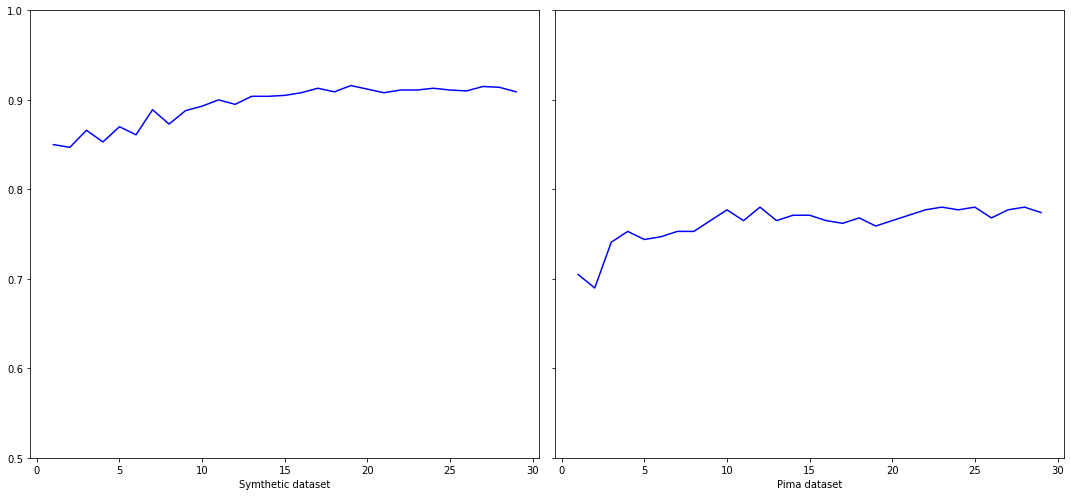

In [1312]:
fig, ax = plt.subplots(ncols = 2, nrows = 1,figsize = (15,7),sharey = True)
ax0 = ax[0]
ax1 = ax[1]

ax0.plot(np.arange(k_min,k_max), Acc_all_th, label = 'synthetic dataset', color = 'blue')
ax0.set_ylim([0.5,1])
ax0.set_xlabel('Symthetic dataset')
ax1.plot(np.arange(k_min,k_max), Acc_all_pi, label = 'pima dataset', color = 'blue')
ax1.set_xlabel('Pima dataset')
plt.tight_layout()
plt.savefig(r'../figures/acc.vs.k.jpg')

In [1325]:
idx_max = Acc_all_th.index(max(Acc_all_th))
print('synthetic data performance with best overall accuracy\n', 
      'K is: ', idx_max + 1,'\n',
      'overall accuracy:',max(Acc_all_th), '\n'
      'classwise accuracy:\n', Acc_class_th[idx_max],'\n',
      'run time is {} seconds'.format(Rt_th[idx_max]))

idx_max = Acc_all_pi.index(max(Acc_all_pi))

print('pima data performance with best overall accuracy\n', 
      'K is: ', idx_max + 1, '\n',
      'overall accuracy:',max(Acc_all_pi), '\n',
      'classwise accuracy:\n', Acc_class_pi[idx_max],'\n',
       'run time is {} seconds'.format(Rt_pi[idx_max]))


synthetic data performance with best overall accuracy
 K is:  19 
 overall accuracy: 0.916 
classwise accuracy:
    category  cate_size  class_acc
0         0        500      0.926
1         1        500      0.906 
 run time is 2.21289324760437 seconds
pima data performance with best overall accuracy
 K is:  12 
 overall accuracy: 0.7801204819277109 
 classwise accuracy:
    category  cate_size  class_acc
0         0        109   0.577982
1         1        223   0.878924 
 run time is 1.0158772468566895 seconds


In [347]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [883]:
# for synthetic dataset
x_te_0 = Xtest_th[ytest_th==0].reset_index(drop=True)  # class 0 
x_te_1 = Xtest_th[ytest_th==1].reset_index(drop=True)  # class 1

number_points = 50

xy_up = Xtest_th.max(axis = 0).tolist()
xy_low = Xtest_th.min(axis = 0).tolist()

xx = np.linspace(xy_low[0], xy_up[0], number_points)
yy = np.linspace(xy_low[1], xy_up[1], number_points)

XX, YY = np.meshgrid(xx, yy)
zz = np.array([np.ravel(XX),np.ravel(YY)]).T

# decision boundary
mpp = mpp_classifier(Xtrain_th, ytrain_th, xx)
yy_edist = mpp.euclidean_distance()
yy_mdist = mpp.mahalanobis_distance()
xx_qdist, yy_qdist =  mpp.generic_distance()

# get label
t1 = time.time()
best_k = 19
xtest_ = pd.DataFrame(zz)
ZZ,_,_,_ = syn.predict(best_k, xtest_, None, Xtrain_th, ytrain_th)  # not test label, just use the predict results
ZZ = np.array(ZZ).reshape(XX.shape)
print('Run time:',(time.time() - t1))

0.59484910208*x1 + 0.71442794512*x2 - 0.317050246919288

Matrix([[2.94239558705424*x1 + 21.8174879666796*x2 - 10.7898275662935]])

'Discriminant function'

Matrix([[1.46768684748451*x1**2 + 4.56561613528624*x1*x2 - 4.02302130593299*x1 + 3.56103245543682*x2**2 - 14.8888425980496*x2 + 6.34986103776841]])

Run time: 5.92831826210022


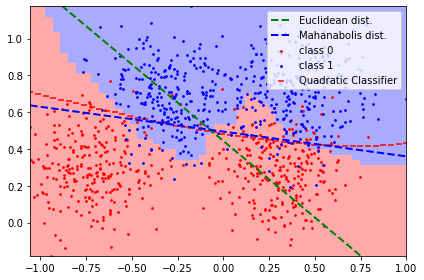

In [887]:
fig, ax  = plt.subplots()

ax.scatter(x_te_0['xs'], x_te_0['ys'], color = 'red',label = 'class 0', zorder = 2, s= 3)
ax.scatter(x_te_1['xs'], x_te_1['ys'], color = 'blue', label = 'class 1', zorder = 2, s = 3)
ax.pcolormesh(XX, YY, ZZ, cmap=cmap_light, zorder = 0)
# plot the decision boundaries for three classifiers
ax.plot(xx, yy_edist, color = 'g',linestyle = '--',linewidth = 2, label = 'Euclidean dist.')
ax.plot(xx, yy_mdist, color = 'b', linestyle = '--', linewidth = 2, label = 'Mahanabolis dist.')
ax.scatter(xx_qdist, yy_qdist, c= 'r', marker = "_", label = 'Quadratic Classifier')
ax.legend(loc = 'upper right')
ax.set_ylim([xy_low[1], xy_up[1]])
ax.set_xlim([xy_low[0], xy_up[0]])


plt.tight_layout()
plt.savefig(r'../figures/kNNboundaryall.jpg')

### Task 2
: Implement unsupervised clustering approaches (kmeans and wta) for classification purpose.Using the pima dataset. For fair comparison, make sure you use the statistics derived from the training set to normalize the test set, like you did in Project 1. That is, the clustering approaches need to use the normalized testset. Assume the number of clusters is 2. Also assume the prior probability ratio is 1:3 wherever needed.

In [1690]:
class unsupervised_learning:
    '''
    enclose two unsupervised learning approaches, kmeans and wta
    note that current version only works for two clusters.  
    '''
    
    def __init__(self, X_test, k):
        
        self.X_test = X_test      #input data features, without labels
        self.sample_size = X_test.shape[0]
        self.nfe         = X_test.shape[1]
        self.k           = k       # number of clusters
        print('Number of samples :', self.sample_size)
        
        
    def _initilize_parameters(self):
        '''
        edit on Tuesday, Spe 21, 2021 10:16 Am
        initialization
        to generate 2 arbitrary clusters and calcualte the centroids and label the clusters.
        
        return  new_centroids_1   --> centroids of cluster 1
                new_centroids_2   --> centroids of cluster 2
                new_label         --> label of input data generated by the two selected clusters.
        '''
        
        # assume we split the xtest into two even set.
        if self.k == 2:
            
            set1 = self.X_test.sample(frac = 0.5, random_state= 1)
            set1_id = set1.index.tolist()
            new_centroids_1 = set1.mean(axis = 0)

            set2 = self.X_test.drop(set1_id)
            set2_id = set2.index.tolist()
            new_centroids_2 = set2.mean(axis = 0)
    #         print(new_centroids_2.reset_index(drop=True))

            # initialize a original label
            new_labels = np.zeros(self.sample_size).reshape(self.sample_size,1)
            new_labels[set1_id] = 0
            new_labels[set2_id] = 1
#             print('===========check', new_centroids_1)
            centroids = [new_centroids_1, new_centroids_2]
            
        if self.k > 2 :
            '''generalized the model while keeping the old version'''
            centroids = []
            new_labels = np.zeros(self.sample_size).reshape(self.sample_size,1)
            kk = self.k
            while (kk > 0):
                
                grp = self.X_test.sample(frac = 1/k, random_state = kk)
                grp_idx = grp.index.tolist()
                c       = grp.mean(axis = 0)
                
                kk -= 1
                centroids.append(c)
                new_labels[grp_idx] = kk  # to make sure k can take 0 
        
        return centroids, new_labels
       
        
        
    def assign_centroids(self, row, centroids):
        '''
        this function is for kmeans to label each sample in test set.
        args row  --> a sample in test set
             centroids --> centroids coordinate 
        return   label 
        '''
        dist2centroid = [(((center - row)**2).sum())**0.5 for center in centroids]  # which is a list 
        min_dist = min(dist2centroid)
        
        label = dist2centroid.index(min_dist)

        return label
    
    def assign_centroids_(self, row, centroids, pw):
        '''
        consider the prior information
        this function is for kmeans to label each sample in test set.
        args row  --> a sample in test set
             centroids --> centroids coordinate 
        return   label 
        '''
        dist2centroid = [(((center - row)**2).sum())**0.5 for center in centroids]  # which is a list 
        sum_dist = sum(dist2centroid)
        dist2centroid_weighted = [y/x for x, y in zip(dist2centroid, pw)]
#         print(dist2centroid_weighted)
#         min_dist = min(dist2centroid)
        min_dist = min(dist2centroid_weighted)
        
        label = dist2centroid_weighted.index(min_dist)

        return label
    
    
    def get_centroids_kmeans(self, y_model):
        '''this function is used to calculate the centroids coorindates  K element list '''
        
        centroids = [self.X_test[np.array(y_model) == i].mean(axis = 0).to_numpy() for i in range(self.k)]          

        return centroids       
    
    def get_centroids_kmeans_(self, y_model, pw):
        '''Wednesday'''
        '''consider the prior information'''
        '''yangsong at 11:36 AM Wednesday Sep 22 '''
        '''prior information just describes the frequency of each class'''
        '''this function is used to calculate the centroids coorindates  K element list '''
        '''
        prior information could instruct on selecting the most N important or closest samples near each cluster centorid.
        for instance, after the first epoch, label 0 gets 100 samples while label 1 gets 150 samples, the prior of lable 0 and lablel 1 is 0.7:0.3,
        apparently, there are some class 1 potentially misclassified. thus we can use the 3/(3+7) * (100+150) nearest samples to form a new centroid for cluster 1.
        while use the full samples to update class 0 centroid.
        '''
        
        label_count = [y_model.count(x) for x in range(self.k)]
        label_freq = [x/sum(label_count) for x in label_count]
        # step 1, compare with prior information
        perct = []  # store the number of samples used in each cluster to form the cluster center. 
        for x, y in zip(label_freq, pw):
             
            if x > y:
                '''if number of classified samples is more than prior frequency'''
                '''take a portion of nearest samples to cluster'''
                percent_data = y * int(self.sample_size)    # take at most percent_data to to form the centorid.
            else:
                percent_data = x * sum(label_count)             # use all data samples in the cluster.
            
            perct.append(percent_data)

        # step 2, search the nearest "percent_data" in each cluster and calculate the mean (centroids)
        centroids = []
        for l in range(self.k):
#             print(l)
            cluster_ = self.X_test[np.array(y_model) == l].to_numpy()
            
            centroid_ = cluster_.mean(axis = 0).reshape(1, self.nfe)   # 1 by nfe
            
#             print(cluster_.shape, centroid_.shape)
            dist_ = np.square(np.subtract(cluster_ ,centroid_)).sum(axis = 1)
            neigh_idx = np.argsort(dist_)
            
#             print(neigh_idx, perct)
            partial_data_ = cluster_[neigh_idx[:int(perct[l])],:]   # take a parital data to update centroid.
            
            new_centroid_ = partial_data_.mean(axis = 0) 
        
            centroids.append(new_centroid_)
            
#         centroids = [self.X_test[np.array(y_model) == i].mean(axis = 0).to_numpy() for i in range(self.k)]          

        return centroids  

    
    def get_centroids_wta(self, label, row, centroids, learning_rate):

        centroids[label] = centroids[label] + learning_rate * (row - centroids[label])
        
        return centroids
    
    def Kmeans(self):

        '''
        Kmean algorithm, default k = 2, this function needs to be improved for other K values
        args  X_test --> dataset
              epsilon --> when the old centroids and new centroids is within epsilon, then stop the loop, epsilon is a very small number.
        return  performance of each epoch
              new_labels --> classification results
        '''    
        diff_label = float('inf') # initialize a eror for starting loop, defined by the percent of memership changed after each epoch
        epoch = 0
        membership = []   # to store the percent of smaples changing membership
#         new_centroids_1, new_centroids_2, new_labels = self._initilize_parameters()
        centroids, new_labels = self._initilize_parameters()
#         print(centroids)
        t1 = time.time()
    
        while (diff_label>0):

            old_labels = new_labels        

            y_model = []
            for idx, row in self.X_test.iterrows():
                
                # assign labels
                label = self.assign_centroids(row, centroids)
                y_model.append(label)

            # update the centroids
            centroids = self.get_centroids_kmeans(y_model)  # note that X_test is binded to the self object

            new_labels = np.array(y_model).reshape(self.sample_size,1)

            diff_label = np.sum(new_labels != old_labels)/self.sample_size
            
            epoch += 1

            membership.append([epoch, diff_label])

        t2 = time.time()
        
        print('Run time is {} seconds'.format(t2-t1))

        performance = pd.DataFrame(membership,columns = ['epoch','pect_change'])

        return performance, new_labels
    
    
    def wta(self,learning_rate):

        '''
        winner take all clustering algorithm, now only used for two classes. 
        edit on: Saturday Sep 18, 19:20 
        '''
        diff_label = float('inf') # initialize a eror for starting loop, defined by the percent of memership changed after each epoch
        epoch = 0
        membership = []   # to store the percent of smaples changing membership
        sample_size = self.X_test.shape[0]
        t1 = time.time()
        centroids, new_labels = self._initilize_parameters()

        t1 = time.time()

        while (diff_label>0):

            old_labels = new_labels 
            y_model = []

            for idx, row in self.X_test.iterrows():
                
                # label sample in test set.
                label = self.assign_centroids(row, centroids)
                y_model.append(label)
                # update the centroids 
                centroids = self.get_centroids_wta(label, row, centroids, learning_rate)

            # compute the percent of membership changed
            new_labels = np.array(y_model).reshape(self.sample_size,1)
            diff_label = np.sum(new_labels != old_labels)/self.sample_size

            epoch += 1
            membership.append([epoch, diff_label])

        t2 = time.time()

        print('winner take all clustering, run time is {:.4f} seconds'.format(t2-t1))

        performance = pd.DataFrame(membership,columns = ['epoch','pect_change'])   

        return performance, new_labels
        
        
    def Kmeans_prior(self,pw):

        '''
        Kmean algorithm, default k = 2, this function needs to be improved for other K values
        args  X_test --> dataset
              epsilon --> when the old centroids and new centroids is within epsilon, then stop the loop, epsilon is a very small number.
        return  performance of each epoch
              new_labels --> classification results
        '''    
        diff_label = float('inf') # initialize a eror for starting loop, defined by the percent of memership changed after each epoch
        epoch = 0
        membership = []   # to store the percent of smaples changing membership
#         new_centroids_1, new_centroids_2, new_labels = self._initilize_parameters()
        centroids, new_labels = self._initilize_parameters()
#         print(centroids)
        t1 = time.time()

        while (diff_label>0):

            old_labels = new_labels        

            y_model = []
            for idx, row in self.X_test.iterrows():

                # assign labels
                label = self.assign_centroids(row, centroids)
                y_model.append(label)

            # update the centroids            
            # consider prior information
            centroids = self.get_centroids_kmeans_(y_model, pw)

            new_labels = np.array(y_model).reshape(self.sample_size,1)

            diff_label = np.sum(new_labels != old_labels)/self.sample_size

            epoch += 1

            membership.append([epoch, diff_label])

        t2 = time.time()

        print('Run time is {} seconds'.format(t2-t1))

        performance = pd.DataFrame(membership,columns = ['epoch','pect_change'])

        return performance, new_labels


In [1682]:
k = 2
unsup_learning = unsupervised_learning(Xtest_pi, k) #initialization

Number of samples : 332


In [1689]:
t1 = time.time()
P0 = np.arange(0.1,1,.05)
kmeans_res = []
for p0 in P0:
    pw = [p0, 1-p0]
    kmeans_performance, kmeans_label = unsup_learning.Kmeans_prior(pw)
    acc_overall, acc_class = pima.accuracy_score(ytest_pi.tolist(), kmeans_label.flatten().tolist())
    kmeans_res.append([p0, acc_overall, acc_class])
t2 = time.time()
print('total elapsed time {:.4f} seconds'.format(t2-t1))

Run time is 3.7689030170440674 seconds
Run time is 1.1070952415466309 seconds
Run time is 2.729072093963623 seconds
Run time is 3.7181084156036377 seconds
Run time is 1.6581146717071533 seconds
Run time is 3.3090269565582275 seconds
Run time is 3.0578575134277344 seconds
Run time is 1.543654203414917 seconds
Run time is 1.751624345779419 seconds
Run time is 1.926943302154541 seconds
Run time is 1.5620040893554688 seconds
Run time is 1.7778031826019287 seconds
Run time is 2.618330240249634 seconds
Run time is 4.126143932342529 seconds
Run time is 2.699039936065674 seconds
Run time is 2.4131875038146973 seconds
Run time is 3.30669903755188 seconds
Run time is 2.78909969329834 seconds
total elapsed time 46.0949 seconds


In [1701]:
df_kmeans = pd.DataFrame(kmeans_res, columns = ['p0','acc_over','acc_class'])
optimal_p0 = df_kmeans['p0'][df_kmeans.acc_over.idxmax()]
df_kmeans, print('Overall accuracy reaches the peak when p0 takes', optimal_p0)

Overall accuracy reaches the peak when p0 takes 0.5000000000000001


(      p0  acc_over                                          acc_class
 0   0.10  0.680723     category  cate_size  class_acc
 0         0 ...
 1   0.15  0.698795     category  cate_size  class_acc
 0         0 ...
 2   0.20  0.680723     category  cate_size  class_acc
 0         0 ...
 3   0.25  0.677711     category  cate_size  class_acc
 0         0 ...
 4   0.30  0.707831     category  cate_size  class_acc
 0         0 ...
 5   0.35  0.680723     category  cate_size  class_acc
 0         0 ...
 6   0.40  0.680723     category  cate_size  class_acc
 0         0 ...
 7   0.45  0.710843     category  cate_size  class_acc
 0         0 ...
 8   0.50  0.716867     category  cate_size  class_acc
 0         0 ...
 9   0.55  0.707831     category  cate_size  class_acc
 0         0 ...
 10  0.60  0.710843     category  cate_size  class_acc
 0         0 ...
 11  0.65  0.707831     category  cate_size  class_acc
 0         0 ...
 12  0.70  0.704819     category  cate_size  class_acc
 0        

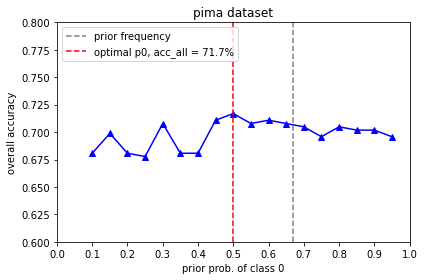

In [1705]:
fig, ax = plt.subplots()
ax.plot(df_kmeans.p0, df_kmeans.acc_over, color = 'blue', marker = '^')
ax.set_xlim([0,1])
ax.set_xlabel('prior prob. of class 0')
ax.set_ylabel('overall accuracy')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_xlim([0,1])
ax.set_ylim([0.6,0.8])
ax.axvline(x= 0.67,linestyle = '--',color = 'grey',label ='prior frequency')
ax.axvline(x = optimal_p0, linestyle  = '--', color = 'red',label= 'optimal p0, acc_all = 71.7%')
ax.set_title('pima dataset')
ax.legend()
plt.tight_layout()
plt.savefig('../figures/kmeans_prior_pima.jpg')

Run time is 2.0089111328125 seconds


(0.0, 0.5)

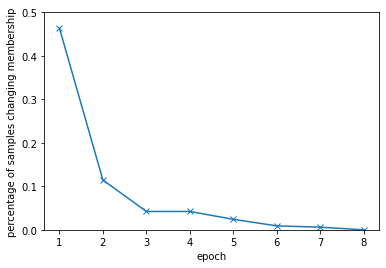

In [1282]:
kmeans_performance, kmeans_label = unsup_learning.Kmeans()
fig, ax = plt.subplots()
ax.plot(kmeans_performance.epoch, kmeans_performance.pect_change,marker = 'x')
# ax.plot(performance.epoch, performance.iter_error)
ax.set_xlabel('epoch')
ax.set_ylabel('percentage of samples changing membership')
ax.set_ylim([0,0.5])

In [1305]:
learning_rate = 0.05
wta_performance_0, wta_label_0 = unsup_learning.wta(learning_rate)

winner take all clustering, run time is 0.9696 seconds


In [1184]:
learning_rate = 0.1
wta_performance_1, wta_label_1 = unsup_learning.wta(learning_rate)

winner take all clustering, run time is 0.9924 seconds


In [1307]:
pima.accuracy_score(ytest_pi.tolist(), wta_label_0.flatten().tolist()), wta_performance_0.epoch

((0.713855421686747,
     category  cate_size  class_acc
  0         0        109   0.724771
  1         1        223   0.708520),
 0    1
 1    2
 2    3
 Name: epoch, dtype: int64)

winner take all clustering, run time is 0.6888 seconds


(0.0, 0.5)

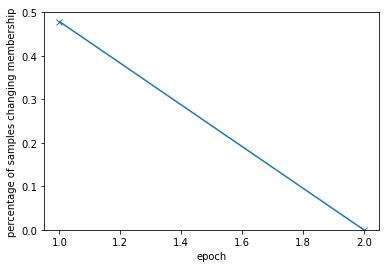

In [1208]:
learning_rate = 0.2
wta_performance_2, wta_label_2 = unsup_learning.wta(learning_rate)
fig, ax = plt.subplots()
ax.plot(wta_performance_2.epoch, wta_performance_2.pect_change,marker = 'x')
# ax.plot(performance.epoch, performance.iter_error)
ax.set_xlabel('epoch')
ax.set_ylabel('percentage of samples changing membership')
ax.set_ylim([0,0.5])

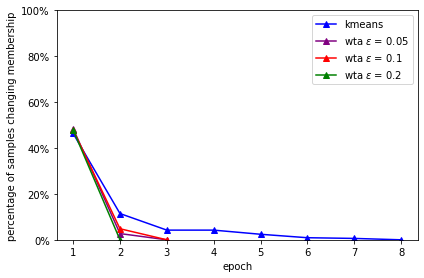

In [1308]:
## plot overlap
import matplotlib.ticker as mtick
fig, ax = plt.subplots()

ax.plot(kmeans_performance.epoch, kmeans_performance.pect_change*100,marker = '^',color = 'blue',label= 'kmeans')
ax.plot(wta_performance_0.epoch, wta_performance_0.pect_change*100,marker = '^',color = 'purple',label = 'wta $\epsilon$ = 0.05')
ax.plot(wta_performance_1.epoch, wta_performance_1.pect_change*100,marker = '^',color = 'red',label = 'wta $\epsilon$ = 0.1')
ax.plot(wta_performance_2.epoch, wta_performance_2.pect_change*100,marker = '^',color = 'green',label = 'wta $\epsilon$ = 0.2')
ax.set_ylim([0,100])
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('epoch')
ax.set_ylabel('percentage of samples changing membership')
plt.tight_layout()
plt.savefig(r'../figures/kmeans_wta.a.jpg')


In [1309]:
print('accuracy of kmeans clustering')

display(pima.accuracy_score(ytest_pi.tolist(), kmeans_label.flatten().tolist()))

print('accuracy of wta clustering')
pima.accuracy_score(ytest_pi.tolist(), wta_label_0.flatten().tolist())

accuracy of kmeans clustering


(0.7108433734939759,
    category  cate_size  class_acc
 0         0        109   0.688073
 1         1        223   0.721973)

accuracy of wta clustering


(0.713855421686747,
    category  cate_size  class_acc
 0         0        109   0.724771
 1         1        223   0.708520)

## Bonus question

### KNN with prior information

* test on synthetic dataset

In [ ]:
t1 = time.time()
syn = knn(dataset_name ='synthetic', k_min = k_min, k_max = k_max)
val_acc_over = []
val_acc_class = []
P0 = np.arange(0.1,1,.05)
for p0 in P0:
    pw = [p0, 1- p0]
    _,_, acc_over_1, acc_class_1 = syn.predict_(K, Xtest_th, ytest_th, Xtrain_th, ytrain_th,pw, '1')  # 1 is case 1
    _,_, acc_over_2, acc_class_2 = syn.predict_(K, Xtest_th, ytest_th, Xtrain_th, ytrain_th,pw, '2')  # 1 is case 1
    _,_, acc_over_3, acc_class_3 = syn.predict_(K, Xtest_th, ytest_th, Xtrain_th, ytrain_th,pw, '3')  # 1 is case 1
    val_acc_over.append([p0, acc_over_1, acc_over_2, acc_over_3])
    val_acc_class.append([p0, acc_class_1, acc_class_2, acc_class_3])
print(time.time()-t1) 

df_res = pd.DataFrame(val_acc_over, columns = ['p0','case1','case2','case3'])
display(df_res)

import matplotlib.ticker as ticker
fig, ax = plt.subplots()
ax.plot(df_res.p0, df_res.case1, marker = '^',color = 'blue', label = 'approach 1')
ax.plot(df_res.p0, df_res.case2, marker = '^', color = 'red', label = 'approach 2')
ax.plot(df_res.p0, df_res.case3, marker = '^', color = 'green', label = 'approach 3')
ax.legend()
ax.set_ylabel('overall accuracy')
ax.set_xlabel('prior prob. of class 0')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_xlim([0,1])
ax.axvline(x= 0.5,linestyle = '--',color = 'grey')
ax.set_title('synthetic dataset')
plt.tight_layout()
plt.savefig('../figures/knn_prior.jpg')

* test on pima dataset

In [ ]:
t1 = time.time()
pima = knn(dataset_name ='pima', k_min = k_min, k_max = k_max)
val_acc_over = []
val_acc_class = []
P0 = np.arange(0.1,1,.05)
K = 12
for p0 in P0:
    pw = [p0, 1- p0]
    _,_, acc_over_1, acc_class_1 = pima.predict_(K, Xtest_pi, ytest_pi, Xtrain_pi, ytrain_pi,pw, '1')  # 1 is case 1
    _,_, acc_over_2, acc_class_2 = pima.predict_(K, Xtest_pi, ytest_pi, Xtrain_pi, ytrain_pi,pw, '2')  # 1 is case 1
    _,_, acc_over_3, acc_class_3 = pima.predict_(K, Xtest_pi, ytest_pi, Xtrain_pi, ytrain_pi,pw, '3')  # 1 is case 1
    val_acc_over.append([p0, acc_over_1, acc_over_2, acc_over_3])
    val_acc_class.append([p0, acc_class_1, acc_class_2, acc_class_3])
print(time.time()-t1) 

df_res = pd.DataFrame(val_acc_over, columns = ['p0','case1','case2','case3'])
display(df_res)

fig, ax = plt.subplots()
ax.plot(df_res.p0, df_res.case1, marker = '^',color = 'blue', label = 'approach 1')
ax.plot(df_res.p0, df_res.case2, marker = '^', color = 'red', label = 'approach 2')
ax.plot(df_res.p0, df_res.case3, marker = '^', color = 'green', label = 'approach 3')
ax.legend()
ax.set_ylabel('overall accuracy')
ax.set_xlabel('prior prob. of class 0')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_xlim([0,1])
ax.axvline(x= 0.67,linestyle = '--',color = 'grey')
ax.set_title('pima dataset')
plt.tight_layout()
plt.savefig('../figures/knn_prior_pima.jpg')

In [ ]:
### Kmeans with prior information

### below code is discarded. 

Run time is 1.830353021621704 seconds


(0.0, 0.5)

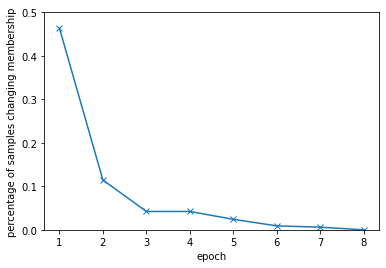

In [1177]:
kmeans_performance, kmeans_label = Kmeans(Xtest_pi)

fig, ax = plt.subplots()
ax.plot(kmeans_performance.epoch, kmeans_performance.pect_change,marker = 'x')
# ax.plot(performance.epoch, performance.iter_error)
ax.set_xlabel('epoch')
ax.set_ylabel('percentage of samples changing membership')
ax.set_ylim([0,0.5])

0
(332, 1)
1
(332, 1)
winner take all clustering, run time is 0.6652 seconds


,epoch,pect_change
0,1,0.478916
1,2,0.000000


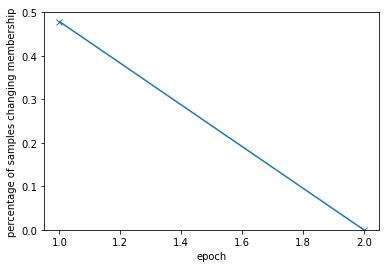

In [1294]:
learning_rate = 0.2
wta_performance_2, wta_label_2 = wta(Xtest_pi, learning_rate)
fig, ax = plt.subplots()
ax.plot(wta_performance_2.epoch, wta_performance_2.pect_change,marker = 'x')
# ax.plot(performance.epoch, performance.iter_error)
ax.set_xlabel('epoch')
ax.set_ylabel('percentage of samples changing membership')
ax.set_ylim([0,0.5])
wta_performance_2

In [ ]:
# winner take all approach

def wta(X_test,learning_rate):
    
    '''
    winner take all clustering algorithm, now only used for two classes. 
    edit on: Saturday Sep 18, 19:20 
    '''
    # assume we split the xtest into two even set.
    set1 = X_test.sample(frac = 0.5, random_state= 1)
    set1_id = set1.index.tolist()
    # Xtest.loc[set1_id, 'label'] = 1
    winer_new_1 = set1.mean(axis = 0)

    set2 = X_test.drop(set1_id)
    set2_id = set2.index.tolist()
    winer_new_2 = set2.mean(axis = 0)
    # initialize the label
    new_labels = np.zeros(sample_size).reshape(sample_size,1)
    new_labels[set1_id] = 0
    new_labels[set2_id] = 1

    diff_label = float('inf')  # kind of error, used to stop the loop, if diff_label == 0, meaning that centroids are not changed. 
    epoch = 0
    membership = []   # to store the percent of smaples changing membership
    t1 = time.time()

    while (diff_label>0):

        old_labels = new_labels 
        y_model = []
        print(epoch)
        for idx, row in X_test.iterrows():
            
            
            winer_old_1 = winer_new_1
            winer_old_2 = winer_new_2
           
            dist2mean_1 = (((winer_old_1 - row)**2).sum())**0.5    # euclidean distance
            dist2mean_2 = (((winer_old_2 - row)**2).sum())**0.5    # euclidean distance
            # compare dist2mean_1 and dist2mean_2
            label =  1 if dist2mean_1 > dist2mean_2 else 0     # two classes, one is 1 and the other is 2
#             neigh = dist2mean_1 if dist2mean_2 > dist2mean_1 else dist2mean_2
            # update the center (winner) 
    #         winer_new = winer_old + learning_rate * (neigh - winer_old)  # modify the winer (center)

            if label == 0:
                winer_new_1 = winer_old_1 + learning_rate * (row - winer_old_1)
                winer_new_2 = winer_old_2
            else:
                winer_new_1 = winer_old_1
                winer_new_2 = winer_old_2 + learning_rate * (row - winer_old_2)
            
            y_model.append(label)
        
        new_labels = np.array(y_model).reshape(sample_size,1)
        print((new_labels != old_labels).shape)
        diff_label = np.sum(new_labels != old_labels)/sample_size

        epoch += 1
#         print('epoch: ',epoch, 'error:',sum_error)
        membership.append([epoch, diff_label])

    t2 = time.time()

    print('winner take all clustering, run time is {:.4f} seconds'.format(t2-t1))
    # Xtest['y_model'] = y_model

    performance = pd.DataFrame(membership,columns = ['epoch','pect_change'])   
    
    
    return performance, new_labels

In [ ]:
# Kmeans algorithm

# Step 1. begin with an arbitrary assignment of samples to clusters or begin with an arbitrary set of cluster centers and assign samples to nearest clusters
def Kmeans(X_test):
    '''
    Kmean algorithm, default k = 2, this function needs to be improved for other K values
    args  X_test --> dataset
          epsilon --> when the old centroids and new centroids is within epsilon, then stop the loop, epsilon is a very small number.
    return  performance of each epoch
          new_labels --> classification results
    '''
    sum_error = float('inf')    # initialize a eror for starting loop, defined by the distance between old center and new center
    diff_label = float('inf')
    epoch = 0
    sample_size = X_test.shape[0]
    # assume we split the xtest into two even set.
    set1 = X_test.sample(frac = 0.5, random_state= 1)
    set1_id = set1.index.tolist()
    new_centroids_1 = set1.mean(axis = 0)

    set2 = X_test.drop(set1_id)
    set2_id = set2.index.tolist()
    new_centroids_2 = set2.mean(axis = 0)
    # Xtest.loc[set2_id, 'label'] = 2

    membership = []   # to store the percent of smaples changing membership
    t1 = time.time()
    # initialize a original label
    new_labels = np.zeros(sample_size).reshape(sample_size,1)
    new_labels[set1_id] = 0
    new_labels[set2_id] = 1
    
    while (diff_label>0):

        old_centroids_1 = new_centroids_1
        old_centroids_2 = new_centroids_2
        old_labels = new_labels        

        y_model = []
        for idx, row in X_test.iterrows():

            dist2mean_1 = (((old_centroids_1 - row)**2).sum())**0.5    # euclidean distance
            dist2mean_2 = (((old_centroids_2 - row)**2).sum())**0.5    # euclidean distance
        # compare dist2mean_1 and dist2mean_2
            label =  1 if dist2mean_1 > dist2mean_2 else  0     # two classes, one is 1 and the other is 2
            y_model.append(label)

        # update mean of each cluster 
        # add one column (label) to the Xtest_pi data for calculate the mean
        set1_mean = X_test[np.array(y_model) == 0].mean(axis = 0).to_numpy()
        set2_mean = X_test[np.array(y_model) == 1].mean(axis = 0).to_numpy()
  
    #     print(Xtest.columns)
        new_centroids_1  = set1_mean
        new_centroids_2  = set2_mean
    #     print(new_centroids_1)
        new_labels = np.array(y_model).reshape(sample_size,1)
        # calcualte the difference 
        
        diff_label = np.sum(new_labels != old_labels)/sample_size
        

        epoch += 1

        membership.append([epoch, diff_label])


    t2 = time.time()
    print('Run time is {} seconds'.format(t2-t1))
    # Xtest['y_model'] = y_model

    performance = pd.DataFrame(membership,columns = ['epoch','pect_change'])
    
    return performance, new_labels

In [310]:
# test sample

t1  = time.time()
k_min, k_max = 1, 30
syn = knn(dataset_name ='synthetic', k_min = k_min, k_max = k_max)
# syn.iter_k()
Rt, Acc_all, Acc_class = syn.iter_k( Xtrain, ytrain,Xtest, ytest)

print('total run time: {:.4f} seconds'.format(time.time() - t1))

synthetic
total run time: 110.3670 seconds


illustrates the overall classification accuracy vs. k using the synthetic and the pima dataset. 

In [255]:
def accuracy_score_(y, y_model):
    """ Return accuracy score.
    You are supposed to return both overall accuracy and classwise accuracy.
    args   y --> label of test sample
           y_model --> label generated from the algorithm, which is a list.
    return acc_overall --> overall accuracy, a scalar
           acc_classwise   --> classwise accuracy a dataframe
    """
    y = y.tolist() if isinstance(y, pd.Series) else y  # if y is a pd.Series, then convert it to list
    
    assert len(y) == len(y_model)
    
    # overall accuracy
    unq_label = np.unique(y)       # unique label

    # classwie accuracy, should consider situations with desigated dimensions
    # use pandas groupby
    # create a pandas dataframe
    df_eval = pd.DataFrame(list(zip(y, y_model)),
               columns =['ytest', 'ymodel'])
    df_eval['acc'] = (df_eval['ytest'] == df_eval['ymodel']).astype(int)
    category_size = df_eval.groupby(['ytest'])['ymodel'].count().reset_index()  # count the samples in each category
    category_acc  = df_eval.groupby(['ytest'])['acc'].sum().reset_index()        # number of accurate label
    
    acc_classwise = pd.merge(category_size, category_acc, on = 'ytest',validate = 'one_to_one')
    acc_classwise['acc'] = acc_classwise['acc']/acc_classwise['ymodel']
    acc_classwise = acc_classwise.rename(columns = {'ytest':'category','ymodel':'cate_size','acc':'class_acc'})
    
    # overall accuracy
    acc_overall = df_eval['acc'].sum()/df_eval.shape[0]
#     print(acc_classwise)

    return acc_overall, acc_classwise


In [279]:
def knn_(K, Xtest, ytest, Xtrain, ytrain):

    y_model = []
    t1 = time.time()
#     K = 3
    for idx, row in Xtest.iterrows():

        # compute (squared or not squared) distance the sample in test set to each sample in training set
        dist2train = (Xtrain.subtract(row)**2).sum(axis = 1)

        neigh_idx = dist2train.sort_values().index[:K].tolist()   # K-nearest neighbour's index
        neigh_label = ytrain[neigh_idx].tolist()

        ## find the marjority of label
        major_label = max(set(neigh_label), key = neigh_label.count)
        
        y_model.append(major_label)

    t2 = time.time()
    acc_all, acc_class = accuracy_score_(ytest, y_model)
#     print('Run time is {:.3f} seconds'.format(t2-t1))
    return y_model, t2 - t1, acc_all, acc_class

In [285]:
Rt = []
Acc_all = []
Acc_class = []
k_max = 20
k_min = 1

for K in range(k_min,k_max):
    
    _ , runtime, acc_all_, acc_class_ = knn_(K, Xtest, ytest, Xtrain, ytrain)
    Rt.append(runtime)
    Acc_all.append(acc_all_)
    Acc_class.append(acc_class_)
        

In [292]:
Acc_all

[0.85,
 0.847,
 0.866,
 0.853,
 0.87,
 0.861,
 0.889,
 0.873,
 0.888,
 0.893,
 0.9,
 0.895,
 0.904,
 0.904,
 0.905,
 0.908,
 0.913,
 0.909,
 0.916]

reference to visualize the boundary of KNN

https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib

Text(0.5, 0, 'K value')

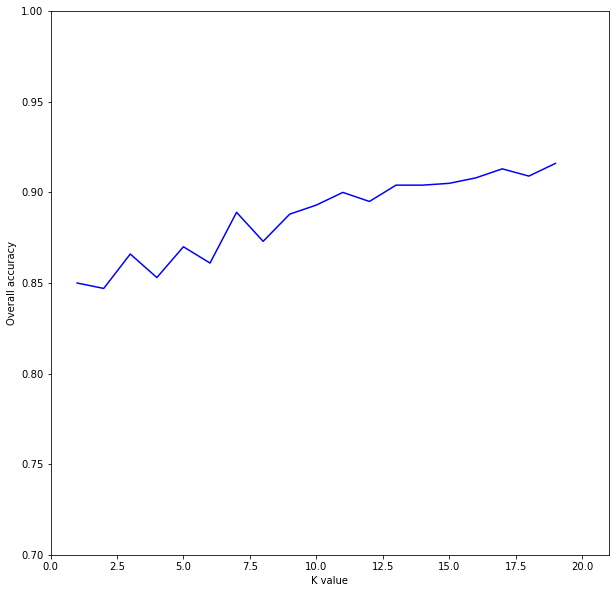

In [290]:
fig, ax = plt.subplots(figsize = (10,10))
k_max = 20
k_min = 1
ax.plot(np.arange(k_min,k_max), Acc_all, color = 'blue')
ax.set_xlim([k_min-1, k_max + 1])
ax.set_ylim([0.7,1])
ax.set_ylabel('Overall accuracy')
ax.set_xlabel('K value')

In [259]:
acc_all, acc_class = accuracy_score(ytest, y_model)
acc_all, acc_class

(0.866,
    category  cate_size  class_acc
 0         0        500      0.898
 1         1        500      0.834)

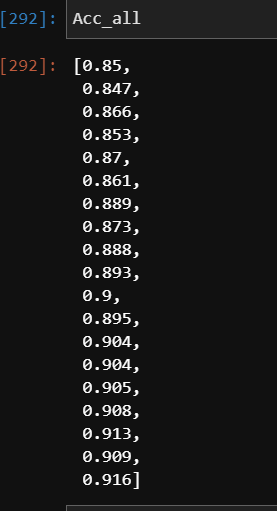

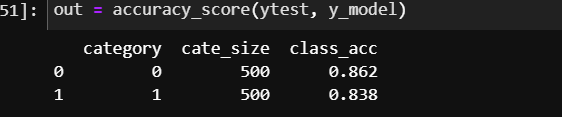